# Diabetes Dataset - EDA

In this notebook, an initial Exploratory Data Analysis (EDA) is performed, followed by data cleaning and the plotting of insights related to the data contained in the dataset `diabetes_unclean.csv`.

## Opening and First look
In this section, the necessary libraries are imported, and a preliminary analysis of the dataset is performed.

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = pd.read_csv('../datasets/diabetes_unclean.csv')

In [5]:
dataset.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26.0,4.5,62.0,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50.0,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33.0,7.1,46.0,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [6]:
print(dataset.columns.values)

['ID' 'No_Pation' 'Gender' 'AGE' 'Urea' 'Cr' 'HbA1c' 'Chol' 'TG' 'HDL'
 'LDL' 'VLDL' 'BMI' 'CLASS']


## Dataset features
In the dataset we can access the following feature:

- **Gender**: The gender of the individual (e.g., Male, Female).
- **AGE**: The age of the individual in years.
- **Urea**: The level of urea in the blood, indicating kidney function. 
- **Cr**: Creatinine level in the blood, used to assess kidney function.
- **HbA1c**: Hemoglobin A1c percentage, a measure of average blood sugar levels.
- **Chol**: Total cholesterol level in the blood, measured in mmol/L, indicating lipid profile.
- **TG**: Triglycerides level in the blood, measured in mmol/L, another component of the lipid profile.
- **HDL**: High-Density Lipoprotein cholesterol, often referred to as "good cholesterol," measured in mmol/L.
- **LDL**: Low-Density Lipoprotein cholesterol, often referred to as "bad cholesterol," measured in mmol/L.
- **VLDL**: Very Low-Density Lipoprotein cholesterol, another type of "bad cholesterol," measured in mmol/L.
- **BMI**: Body Mass Index, a measure of body fat based on height and weight.
- **CLASS**: The target variable indicating the presence or absence of diabetes (e.g., diabetic or non-diabetic).

In [7]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1009 non-null   int64  
 1   No_Pation  1009 non-null   int64  
 2   Gender     1009 non-null   object 
 3   AGE        1008 non-null   float64
 4   Urea       1008 non-null   float64
 5   Cr         1007 non-null   float64
 6   HbA1c      1006 non-null   float64
 7   Chol       1007 non-null   float64
 8   TG         1007 non-null   float64
 9   HDL        1008 non-null   float64
 10  LDL        1007 non-null   float64
 11  VLDL       1008 non-null   float64
 12  BMI        1009 non-null   float64
 13  CLASS      1009 non-null   object 
dtypes: float64(10), int64(2), object(2)
memory usage: 110.5+ KB


In [8]:
dataset.describe()

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1009.000000,1.009000e+03,1008.000000,1008.000000,1007.000000,1006.000000,1007.000000,1007.000000,1008.000000,1007.000000,1008.000000,1009.000000
mean,339.161546,2.717448e+05,53.620040,5.131094,68.973188,8.284155,4.863873,2.348769,1.204216,2.610119,1.850595,29.589911
std,239.738169,3.365681e+06,8.740975,2.931136,59.813297,2.533576,1.297326,1.397487,0.658158,1.116095,3.649859,4.946246
min,1.000000,1.230000e+02,25.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,127.000000,2.406500e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,296.000000,3.439900e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,548.000000,4.539000e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


## Data Cleaning and Preprocessing
In this section, data cleaning is performed by analyzing entries that are outside the acceptable range or are potential outliers. Additionally, preprocessing and encoding of non-numeric or categorical features are carried out.


List of task to be performed in this section:
- Backup the original dataset
- Check for Null values
- Conversion to numerical values or one-hot encoding of the 'object' or 'string' types
- Check for outliers and cleaning


### Backup of the dataset

In [9]:
ds_backup = dataset.copy()
ds_backup.to_csv('../datasets/diabetes_unclean_backup.csv', index=False) # This saves a backup of the original dataset

In [10]:
# counting the number of missing values in each column
dataset.isnull().sum()

ID           0
No_Pation    0
Gender       0
AGE          1
Urea         1
Cr           2
HbA1c        3
Chol         2
TG           2
HDL          1
LDL          2
VLDL         1
BMI          0
CLASS        0
dtype: int64

### Null values 
Since the total entries of the dataset are 1009 and the Null values are less than the 2% of the dataset it is possible to remove them (no fill required)


In [11]:
# Removing the rows with missing values and applying the changes to the dataset
dataset.dropna(inplace=True)

### Conversion to numerical values

In [34]:
dataset.dtypes

Gender      int64
AGE       float64
Urea      float64
Cr        float64
HbA1c     float64
Chol      float64
TG        float64
HDL       float64
LDL       float64
VLDL      float64
BMI       float64
CLASS       int64
dtype: object

Columns to be converted or encoded:
- Gender -> simple encoding [0 = 'M', 1 = 'F']
- Class -> simple encoding [0 = non-positive, 1 = positive]


In [13]:
dataset['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

As there are inconsistencies in the gender column we will perform a 'normalization' of the data and a conversion to numeric value 
```
[0: Male, 1: Female]
```

In [14]:
# Repairing inconcistent values and Encoding of the 'Gender' column
dataset['Gender'] = dataset['Gender'].str.upper().map({'M': 0, 'F': 1})

In [15]:
dataset['CLASS'].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

We can see that there are several unique values with inconsistent syntax, since the possible value of the column `CLASS` are 'Diabetic' or 'Not Diabetic' we will encode it with the following syntax:
```
[Positive to diabetes: 1]
[Negative to diabetes: 0]
```

In [16]:
# Encoding of the 'CLASS' column
# 1. remove unwanted spaces
dataset['CLASS'] = dataset['CLASS'].str.strip()
# 2. raise all values to upper case
dataset['CLASS'] = dataset['CLASS'].str.upper()
# 3. make the values consistent (e.g. P means positive as well as Y, instead, N means negative or simply No)
dataset['CLASS'] = dataset['CLASS'].replace({'P': 'Y'})

# check:
# dataset['CLASS'].unique()

# 4. Encoding of the 'CLASS' column
dataset['CLASS'] = dataset['CLASS'].map({'Y': 1, 'N': 0})

### Unused columns
Some columns are not relevant to predict diabetes. For example, columns like `ID` and `No_Pation` do not provide meaningful information for prediction and can be removed.

In [17]:
# removing unused columns
# backup of the cleaned and encoded dataset
ds_backup = dataset.copy()
# removing unused columns
dataset.drop(columns=['ID', 'No_Pation'], inplace=True)


In [18]:
# Count the occurrences of each class
class_counts = dataset['CLASS'].value_counts()

# Calculate the percentage
class_percentages = (class_counts / len(dataset)) * 100

# Print the results
print("Diabetes (CLASS = 1):")
print(f"Count: {class_counts[1]}, Percentage: {class_percentages[1]:.2f}%")
print("\nNo Diabetes (CLASS = 0):")
print(f"Count: {class_counts[0]}, Percentage: {class_percentages[0]:.2f}%")

Diabetes (CLASS = 1):
Count: 891, Percentage: 89.64%

No Diabetes (CLASS = 0):
Count: 103, Percentage: 10.36%


### Pairplot of the features to get an overall view of the data

In [19]:
#sns.pairplot(dataset, diag_kind='kde', hue='CLASS', plot_kws={'alpha': 0.5})


### Outliers

In this section, we identify outliers to ensure the dataset is consistent, enabling accurate analysis and reliable predictions using future models.

In [20]:
stats = dataset.drop(columns=['Gender', 'AGE']).describe() 
# we lauch the describe() method on the dataset without the 'Gender' and 'AGE' columns 
stats

,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,5.129520,68.742455,8.286378,4.859678,2.343471,1.206187,2.610151,1.859054,29.598612,0.896378
std,2.948246,60.087902,2.542578,1.299625,1.399343,0.662212,1.116133,3.674106,4.963877,0.304923
min,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000,0.000000
25%,3.670000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000,1.000000
50%,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000,1.000000
75%,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000,1.000000
max,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000,1.000000


In [21]:
# Filtering columns with a standard deviation greater than half the mean and store it in a list
features_high_std = stats.columns[stats.loc['std'] > (stats.loc['mean'] / 2)] 
    # stats.loc['std'] returns the standard deviation of each column (looking in the row 'std')
    # stats.loc['mean'] returns the mean of each column (looking in the row 'mean')
    # The result is a boolean array, which we use to filter the columns of the 'stats' DataFrame just created
suspicious_features = features_high_std.tolist
print(suspicious_features)

<bound method IndexOpsMixin.tolist of Index(['Urea', 'Cr', 'TG', 'HDL', 'VLDL'], dtype='object')>


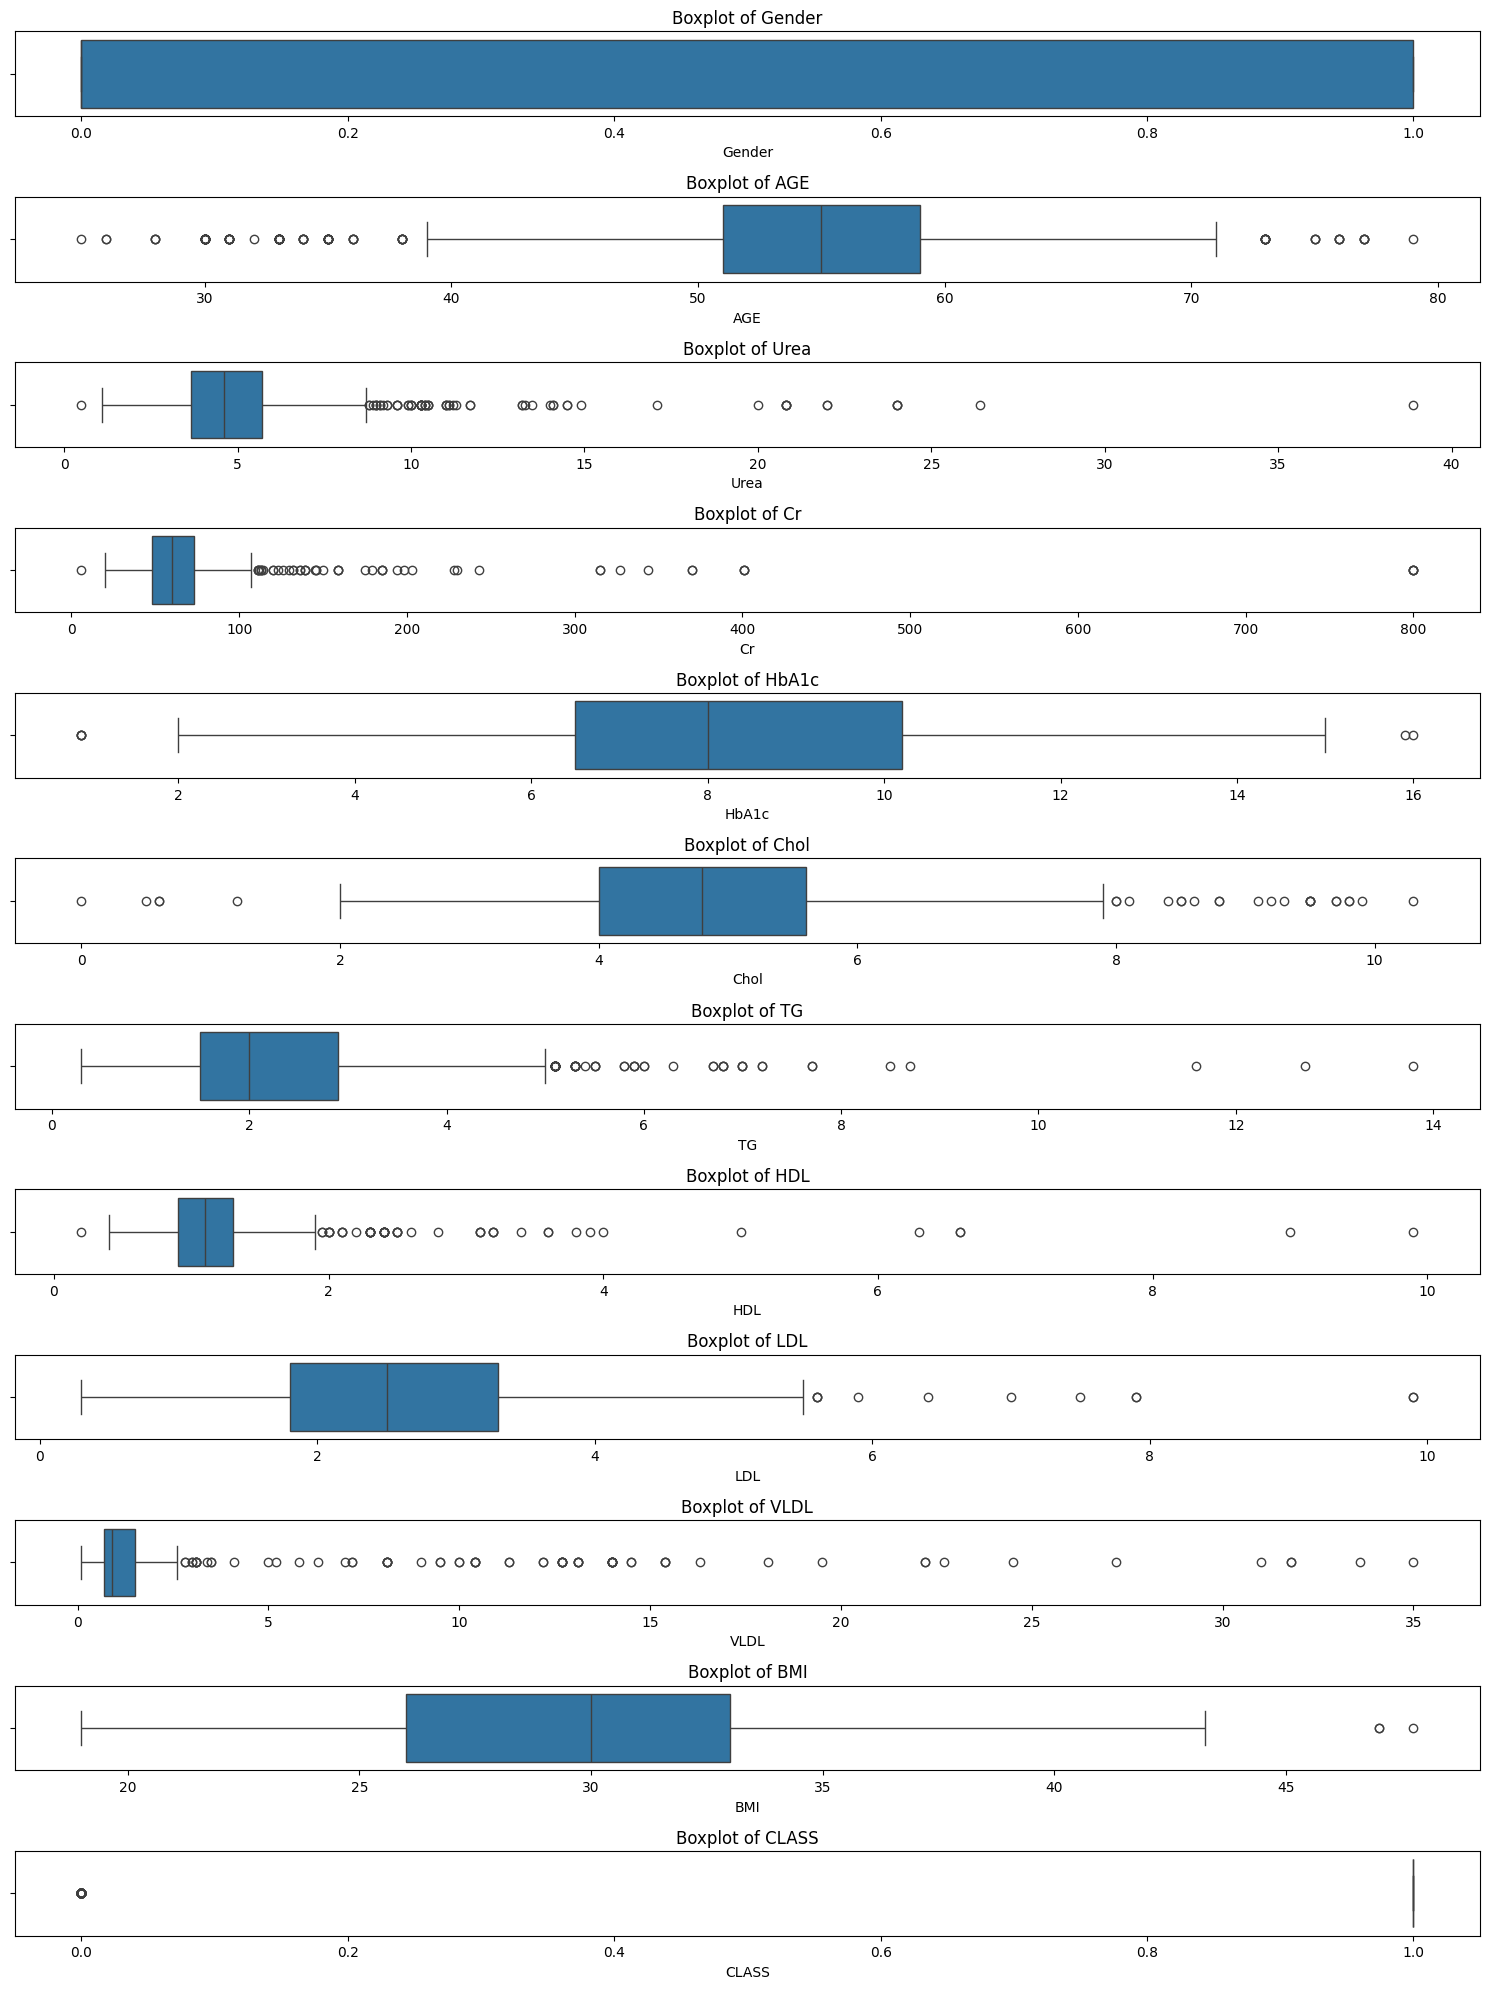

In [22]:
# Plotting the distribution of the features as subplots horizontally
plt.figure(figsize=(15, 20))

# Loop through each feature and create a subplot
for i, feature in enumerate(dataset.columns, 1):
    plt.subplot(len(dataset.columns), 1, i)  # Arrange subplots vertically
    sns.boxplot(data=dataset[feature], orient='h')  # Set orientation to horizontal
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


# Outlier Detection Analysis

## Features Requiring Special Attention

As shown in the preliminary analysis, the features **'Urea', 'Cr', 'TG', 'HDL',** and **'VLDL'** show high values of standard deviation ($\sigma$). Specifically, these columns have standard deviation values higher than half their respective means:

$$\text{Attention required when:}\quad \sigma > \frac{\text{mean}}{2}$$

This indicates potential outliers that warrant further investigation.

## Physiological Limits for Outlier Detection

Physiological ranges and limits:

| Feature | Lower Limit | Upper Limit | Justification |
|---------|-------------|-------------|---------------|
| **Urea** | 1 mmol/L | 25 mmol/L | Values outside this range are extremely rare in living patients and likely represent measurement errors |
| **Cr (Creatinine)** | 10 µmol/L | 400 µmol/L | Values above 400 µmol/L may indicate severe renal failure but could also be data entry errors; values below 10 µmol/L are biologically implausible |
| **TG (Triglycerides)** | 0.1 mmol/L | 10 mmol/L | While normal range is <1.7 mmol/L, values up to 10 mmol/L can occur in severe hypertriglyceridemia or **diabetic** patients |
| **HDL** | 0.3 mmol/L | 5 mmol/L | Values above 5 mmol/L are highly improbable and likely due to laboratory errors or data entry mistakes |
| **VLDL** | 0.05 mmol/L | ? mmol/L | Value derived from a medical equation that considers the levels of TG and cholesterol in the blood. Further investigation needed, possible syntethic values not needed for this project. |


  *! Diclaimer*: The reference values provided are not intended for medical purposes and were obtained through online research. They are not guaranteed to be reliable or representative of the sample in question, as this is not the primary objective of the project.
  Sources: https://www.scymed.com, https://www.my-personaltrainer.it/salute/conversione-colesterolo.html




In [23]:
#                   Urea, Cr,  TG, HDL, VLDL
temp_limits_upper = [25,  400, 10,  5,   40 ]
temp_limits_lower = [1,   10,  0.1, 0.3, 0.05]

#### Summary of actions to verify outliers based on assumptions above
1. First inspection of suspicious features through variance analysis (Box-plot)
2. Identification of the values that exceed the biological plausibility
4. Removal of outliers (or filling, if corrputed data points consists in a larger subset of the dataset)

#####  First inspection of suspicious features through standard deviation analysis (Box-plot)

#### Box-plot of the suspicious feature:
In the plot, it's evident that features such as 'Urea', 'Cr', 'TG', 'HDL', and 'VLDL' exhibit substantial variance with an asymmetric skew towards the upper extremes. However, we can't straightforwardly discard data above the third quartile since these patients might be suffering from diabetes-related pathologies or severe dysfunctions, information that could be needed in the prediction model and further analysis.

#### Identification of the values that exceed the biological plausibility thresholds and removal

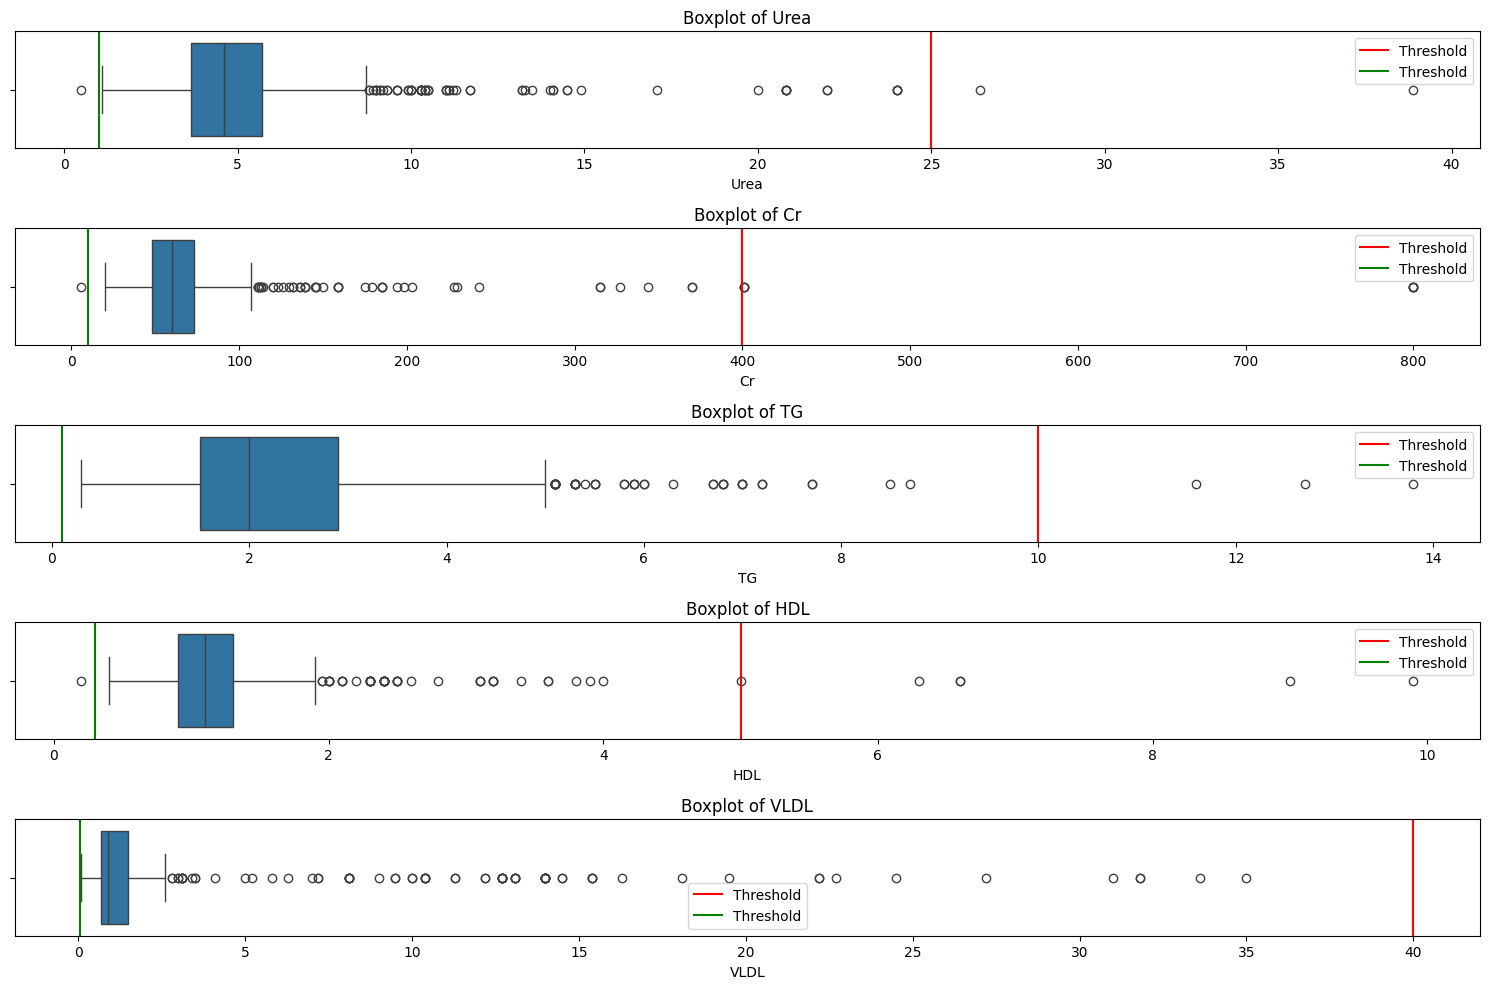

In [24]:

# Plotting the distribution of the features as subplots vertically
plt.figure(figsize=(15, 10))

data = dataset[features_high_std]

# Loop through each feature and create a subplot
for i, feature in enumerate(features_high_std, 1):
    plt.subplot(len(features_high_std), 1, i)  # Arrange subplots vertically
    sns.boxplot(data=data[feature], orient='h')  # Set orientation to horizontal
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    
    # Red line for the upper threshold
    plt.axvline(x=temp_limits_upper[i - 1], color='red', linestyle='-', label='Threshold')
    
    # Ged line for the lower threshold
    if temp_limits_lower[i - 1] > 0:
           plt.axvline(x=temp_limits_lower[i - 1], color='green', linestyle='-', label='Threshold') 

    plt.legend()

plt.tight_layout()
plt.show()


Computing the number of data-points above the thresholds for each abnormal variance column.

In [25]:
# Create a DataFrame to store the results
threshold_table = pd.DataFrame({
    'Feature': features_high_std,    # List of features with high standard deviation
    'Threshold': temp_limits_upper,  # Corresponding upper thresholds for each feature
    'Above upper Threshold': [
        data[feature][data[feature] > temp_limits_upper[i]].count()  # Count values above the threshold
        for i, feature in enumerate(features_high_std)
    ],
    'below lower Threshold': [
        data[feature][data[feature] < temp_limits_lower[i]].count()  # Count values above the threshold
        for i, feature in enumerate(features_high_std)
    ]
})

# Display the table
print(threshold_table)

  Feature  Threshold  Above upper Threshold  below lower Threshold
0    Urea         25                      2                      1
1      Cr        400                      7                      1
2      TG         10                      3                      0
3     HDL          5                      5                      1
4    VLDL         40                      0                      0


#### Removing or replacing outliers
- **TO DO!** : remove or replace?

In [26]:
# replacing with NaN

# Iterate over each feature and its corresponding lower and upper limits
for i, feature in enumerate(features_high_std):
    lower_limit = temp_limits_lower[i] # Where i is the index of the feature in the list 
                                       # and the corresponding upper or lower limit for the feature
                                       # in the list temp_limits_lower or temp_limits_upper
    upper_limit = temp_limits_upper[i]
    
    # Identify rows where the feature value is below the lower limit or above the upper limit
    values_to_remove = (dataset[feature] < lower_limit) | (dataset[feature] > upper_limit)
    
    # Replace outliers with NaN
    dataset.loc[values_to_remove, feature] = np.nan

### VLDL and TG
Since VLDL is a value typically synthetic, we investigate its distribution in relation to TG. The scatter plot below highlights their relationship, showing a positive correlation between the two variables.

VLDL can also be measured directly in some cases, thus the relation with the TG value can be non-linear in some cases.

Formulas for computing VLDL starting from TG:
$$VLDL = \frac{\text{TG}}{5} \quad \text{(mg/dL)}$$ 
$$VLDL = \frac{\text{TG}}{2.2} \quad \text{(mmol/L)}$$

#### Conversion rate between different units of measurement:
- (TG):

$$\text{mmol/L} = \frac{\text{mg/dL}}{88.5}$$
$$\text{mg/dL} = \text{mmol/L} \times 88.5$$

- Cholesterol (LDL, HDL, VLDL, Totale):

$$\text{mmol/L} = \frac{\text{mg/dL}}{38.67}$$
$$\text{mg/dL} = \text{mmol/L} \times 38.67$$


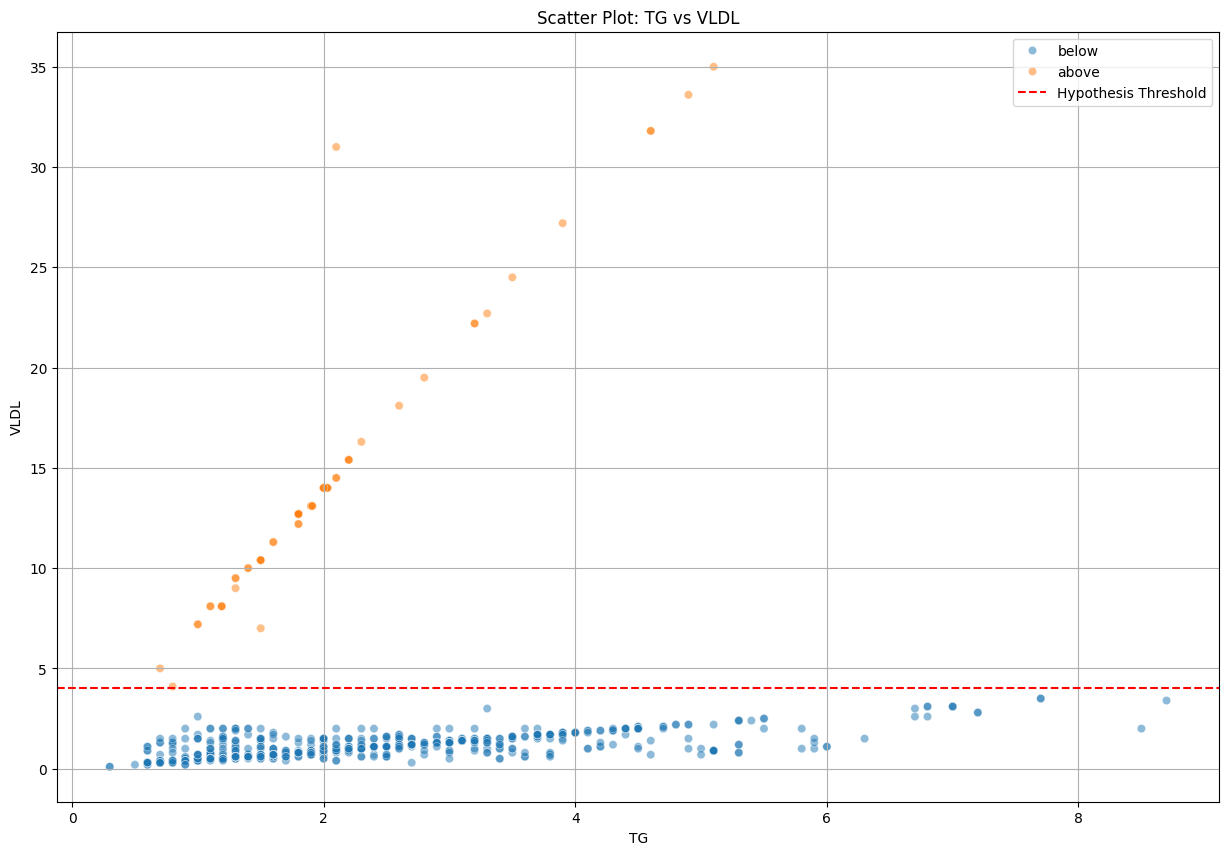

In [27]:
# Scatter plot for TG vs VLDL with color based on threshold
plt.figure(figsize=(15, 10))

# Create a standalone pandas Series to classify points based on the threshold
VLDL_thresh_status = pd.Series(np.where(dataset['VLDL'] > 4, 'above', 'below'), index=dataset.index)



# Scatter plot with color coding
sns.scatterplot(data=dataset, x='TG', y='VLDL', hue=VLDL_thresh_status, alpha=0.5)

plt.title('Scatter Plot: TG vs VLDL')
plt.xlabel('TG')
plt.ylabel('VLDL')
plt.axhline(y=4, color='red', linestyle='--', label='Hypothesis Threshold')
plt.legend()
plt.grid(True)
plt.show()



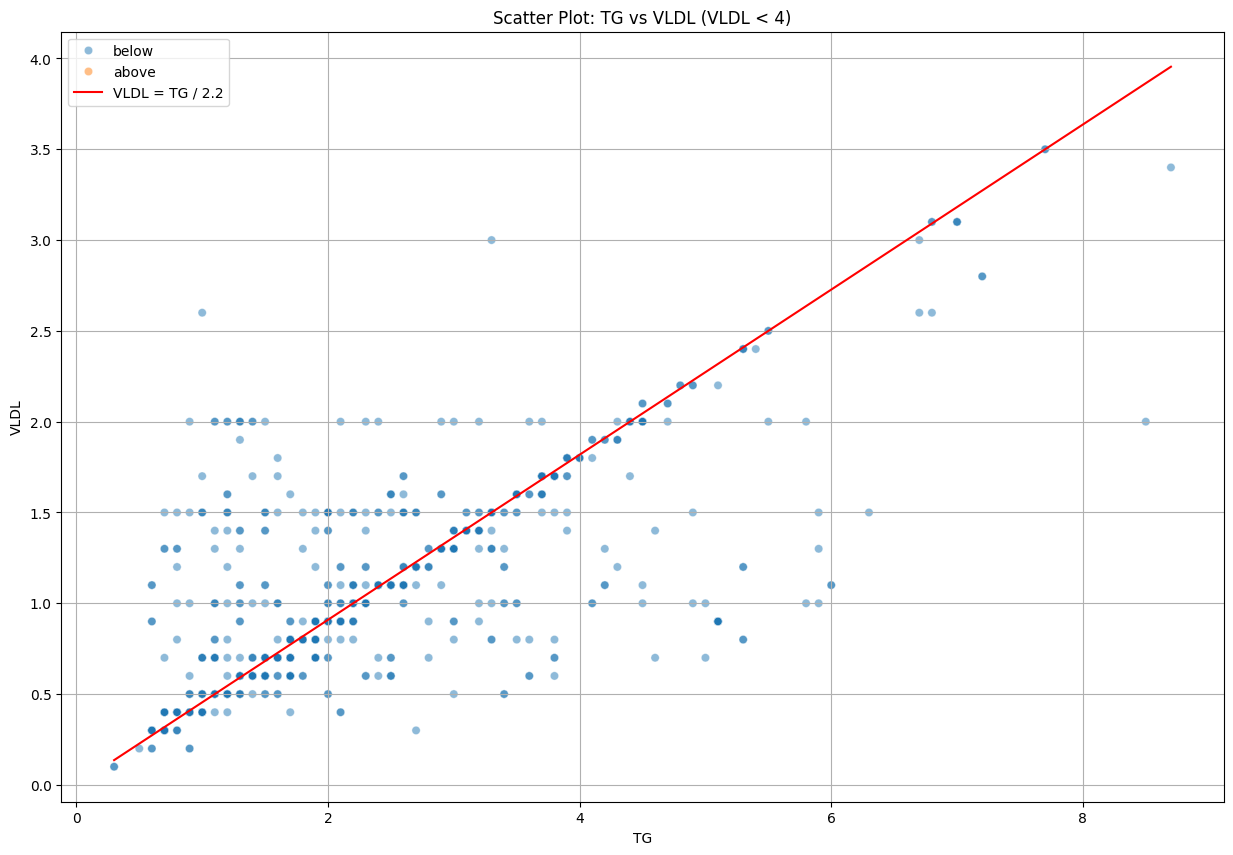

In [28]:
# Filter the dataset for VLDL values under 4
filtered_dataset = dataset[dataset['VLDL'] < 4]

# Scatter plot for TG vs VLDL with VLDL < 4
plt.figure(figsize=(15, 10))
sns.scatterplot(data=filtered_dataset, x='TG', y='VLDL', alpha=0.5, hue=VLDL_thresh_status)
plt.title('Scatter Plot: TG vs VLDL (VLDL < 4)')
plt.xlabel('TG')
plt.ylabel('VLDL')

# Plot the line y = x / 2.2
x_vals = np.linspace(filtered_dataset['TG'].min(), filtered_dataset['TG'].max(), 100)
y_vals = x_vals / 2.2
plt.plot(x_vals, y_vals, color='red', label='VLDL = TG / 2.2')
plt.legend()

plt.grid(True)

plt.show()

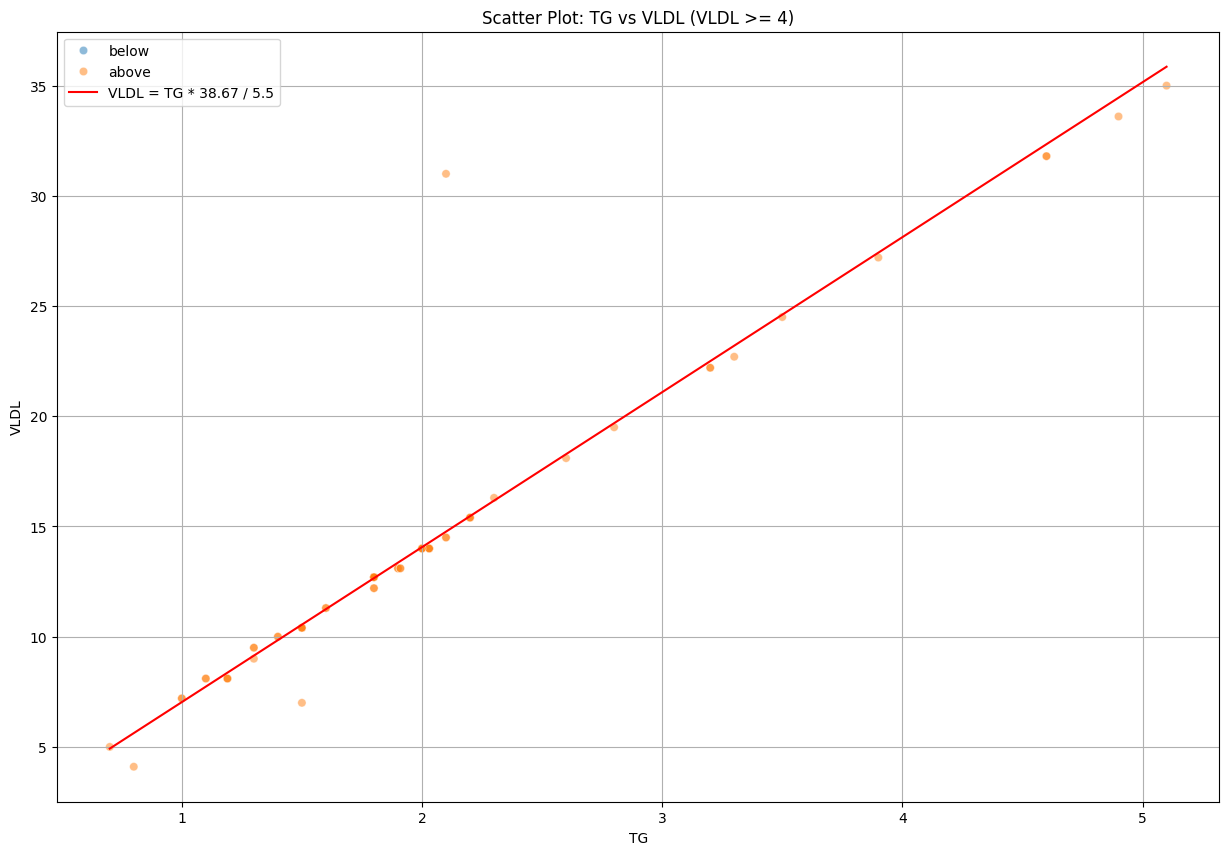

In [29]:
# Filter the dataset for VLDL values over 4
filtered_dataset = dataset[dataset['VLDL'] >= 4]

# Scatter plot for TG vs VLDL with VLDL >= 4
plt.figure(figsize=(15, 10))
sns.scatterplot(data=filtered_dataset, x='TG', y='VLDL', alpha=0.5, hue=VLDL_thresh_status)
plt.title('Scatter Plot: TG vs VLDL (VLDL >= 4)')
plt.xlabel('TG')
plt.ylabel('VLDL')
plt.grid(True)

x_vals = np.linspace(filtered_dataset['TG'].min(), filtered_dataset['TG'].max(), 100)
y_vals = x_vals * 38.67 / 5.5
plt.plot(x_vals, y_vals, color='red', label='VLDL = TG * 38.67 / 5.5')
plt.legend()

# VLDL = TG * 38.67 / 5.5
# TG = VLDL * 5.5 / 38.67
# converted_VLDL = (VLDL * 5.5 / 38.67) / 2.2



plt.show()

### There are two groups of VLDL values, as seen in the graphs above. 

- One group consists of values less than 4, following a pseudo-linear distribution composed of synthetic values derived from the standard formula ($VLDL = TG / 2.2$) with the unit of measurement: mmol/L. 
- The other group exhibits an apparently incorrect trend. Further analysis has demonstrated that the second group represents measurements in a different unit of measurement (mg/dL). 

To homogenize the data, it will be necessary to convert the VLDL measurements back to TG and re-compute the VLDL value as in the other group:  


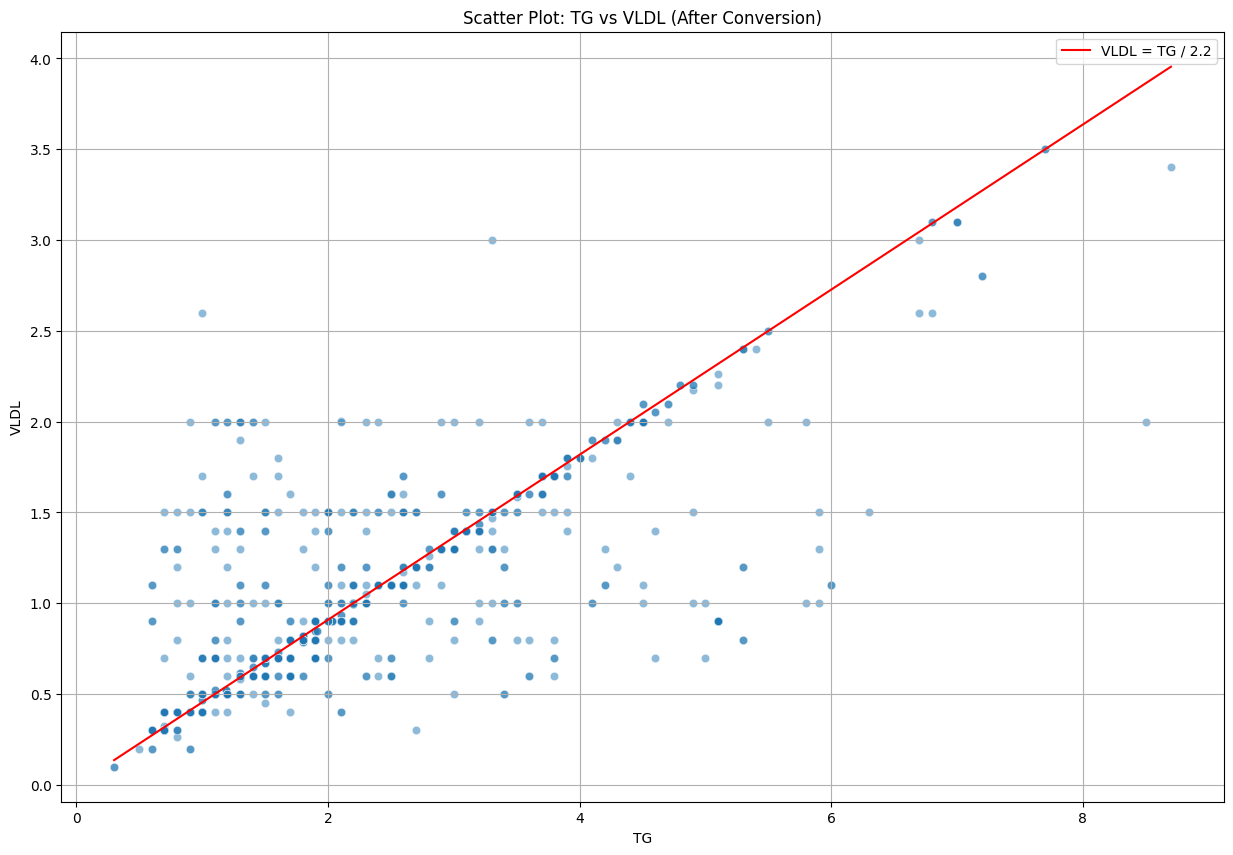

In [30]:
# Convert VLDL values greater than 4 using the new formula
dataset.loc[dataset['VLDL'] > 4, 'VLDL'] = (dataset['VLDL'] * 5.5 / 38.67) / 2.2

# Scatter plot for TG vs VLDL after conversion
plt.figure(figsize=(15, 10))
sns.scatterplot(data=dataset, x='TG', y='VLDL', alpha=0.5)
plt.title('Scatter Plot: TG vs VLDL (After Conversion)')
plt.xlabel('TG')
plt.ylabel('VLDL')

# Plot the line y = x / 2.2
x_vals = np.linspace(dataset['TG'].min(), dataset['TG'].max(), 100)
y_vals = x_vals / 2.2
plt.plot(x_vals, y_vals, color='red', label='VLDL = TG / 2.2')
plt.legend()

plt.grid(True)
plt.show()


In [31]:
# Count the number of rows with one or more NaN values
rows_with_nan = dataset.isnull().any(axis=1).sum()

# Calculate the percentage of rows with NaN values
percentage_with_nan = (rows_with_nan / len(dataset)) * 100

print(f"Number of rows with NaN values: {rows_with_nan}")
print(f"Percentage of rows with NaN values: {percentage_with_nan:.2f}%")

Number of rows with NaN values: 20
Percentage of rows with NaN values: 2.01%


In [32]:
dataset.dropna(inplace=True)

# Saving the cleaned dataset

In [33]:
dataset.to_csv('../datasets/diabetes_cleaned.csv', index=False)